In [2]:
%load_ext autoreload
%autoreload 2

In [49]:
import xarray as xr
import torch
from pathlib import Path
from hython.utils import write_to_zarr, build_mask_dataarray
import matplotlib.pyplot as plt
from pathlib import Path
from hython.datasets.datasets import get_dataset, CubeletsDataset
from numcodecs import Blosc

from torch.utils.data import Dataset, DataLoader

In [26]:
from hython.trainer import HythonDataset
from hython.trainer import train_val
from hython.sampler import SamplerBuilder
from hython.metrics import MSEMetric
from hython.losses import RMSELoss
from hython.utils import read_from_zarr, set_seed
from hython.models.cudnnLSTM import CuDNNLSTM
from hython.trainer import RNNTrainer, RNNTrainParams
from hython.normalizer import Normalizer


from hython.sampler import compute_grid_indices
import itertools


import numpy as np
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset

In [27]:
#from torchvision.datasets import MovingMNIST

In [75]:
dir_surr_input = Path("/mnt/CEPH_PROJECTS/InterTwin/Wflow/models/adg1km_eobs")


static = xr.open_dataset(dir_surr_input / "staticmaps.nc")#.chunk("auto")
dynamic = xr.open_dataset(dir_surr_input/ "forcings.nc").chunk("auto") # C T W H => N T C H W
target = xr.open_dataset(dir_surr_input / "run_default/output.nc").sel(layer=1).isel(lat=slice(None, None, -1))#.chunk("auto") # C T W H => N T C H W


surr_model_output = "convlstm.pt"
experiment = "exp1" # experiment name

dir_surr_output = "/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model"

SEED = 1696

dynamic_names = ["precip", "pet", "temp"] 
static_names = [ 'thetaS', 'thetaR', 'RootingDepth', 'Swood','KsatVer', "Sl"] 
target_names = [ "vwc", "actevap"] 

mask_from_static = ["thetaS","wflow_lakeareas"]
rename_mask = ["mask_missing", "mask_lake"]


dataset = "XBatchDataset"


# DL model hyper parameters
HIDDEN_SIZE = 24
DYNAMIC_INPUT_SIZE = len(dynamic_names)
STATIC_INPUT_SIZE = len(static_names)
KERNEL_SIZE = (3, 3)
NUM_LSTM_LAYER = 2
OUTPUT_SIZE = len(target_names)


TARGET_WEIGHTS = {t:1/len(target_names) for t in target_names}


soil_layers = [1]
# train/test parameters
train_temporal_range = slice("2016-01-01","2018-12-31")
test_temporal_range = slice("2019-01-01", "2020-12-31")

EPOCHS = 50
BATCH = 64
TEMPORAL_SUBSAMPLING = True
TEMPORAL_SUBSET = [150, 150] 
SEQ_LENGTH = 360


assert sum(v for v in TARGET_WEIGHTS.values()) == 1, "check target weights"
TARGET_INITIALS = "".join([i[0].capitalize() for i in target_names])


In [76]:
wd = Path("/mnt/CEPH_PROJECTS/InterTwin/Wflow/models/adg1km_eobs")

In [77]:
try:
    dynamic = dynamic.rename({"latitude":"lat", "longitude":"lon"})
    static = static.rename({"latitude":"lat", "longitude":"lon"})
except:
    pass

In [78]:
# masking 

# filter soil layers 
if len(soil_layers) > 0:
    if len(soil_layers) == 1:
        static = static.sel(layer=soil_layers).squeeze("layer")
        #target = target.sel(layer=soil_layers).squeeze("layer")

    else:
        raise NotImplementedError("Preprocessing multiple soil layers not yet implemented")
    
# masking, TODO: Improve the logic.
masks = []

for i, mask in enumerate(mask_from_static):
    if i == 0:
        masks.append(np.isnan(static[mask]).rename(rename_mask[i]))
    else:
        masks.append((static[mask] > 0).astype(np.bool_).rename(rename_mask[i]))

masks = build_mask_dataarray(masks, names = rename_mask)

In [79]:
# filter 
dynamic = dynamic[dynamic_names]
target = target[target_names]
static = static.drop_dims("time")[ static_names ] 

In [80]:
# # expand static to dynamic 
# time_da = xr.DataArray(dynamic.time.values, [('time', dynamic.time.values)])
# static = static.expand_dims({"time":time_da})

In [81]:
# dynamic = dynamic.to_array() # C T H W
# static = static.to_array() # C T H W
# target = target.to_array() # C T H W

In [82]:
dynamic_train = dynamic.sel(time=train_temporal_range)
static = static#.sel(time=train_temporal_range)
target_train = target.sel(time=train_temporal_range)

dynamic_test = dynamic.sel(time=test_temporal_range)
target_test = target.sel(time=test_temporal_range)

In [83]:
masks = masks.sel(mask_layer=rename_mask).any(dim="mask_layer")

In [84]:
from hython.normalizer import Normalizer

In [85]:
normalizer_dynamic = Normalizer(method = "standardize", type="spacetime", axis_order = "xarray_dataset", dask_compute=False)
normalizer_static = Normalizer(method = "standardize", type="space", axis_order = "xarray_dataset", dask_compute=False)
normalizer_target = Normalizer(method = "standardize", type="spacetime", axis_order = "xarray_dataset", dask_compute=False)

In [86]:
TMP_STATS = "."

In [87]:
dynamic_train = normalizer_dynamic.normalize(dynamic_train, write_to = f"{TMP_STATS}/xd.nc")
static = normalizer_static.normalize(static, write_to = f"{TMP_STATS}/xs.nc")
target_train = normalizer_target.normalize(target_train, write_to = f"{TMP_STATS}/y.nc")

compute stats
save stats
compute stats
save stats
compute stats
save stats


In [88]:
dynamic_test = normalizer_dynamic.normalize(dynamic_test)
target_test = normalizer_target.normalize(target_test)

In [89]:
# temp = dynamic_train.to_stacked_array( new_dim="feat", sample_dims = ["time", "lat", "lon"]) # time, lat, lon , feat
# temp = temp.transpose("time", "feat", "lat" , "lon") # T C H W
# temp = temp.astype("float32")

In [90]:
# # normalize

# normalizer_dynamic = Normalizer(method="standardize", type="spacetime", shape="2D")

# normalizer_static = Normalizer(method="standardize", type="space", shape="2D")

# normalizer_target = Normalizer(method="standardize", type="spacetime", shape="2D")

# normalizer_dynamic.compute_stats(dynamic_train.to_array())
# normalizer_static.compute_stats(static_train.to_array())
# normalizer_target.compute_stats(target_train.to_array())

# dynamic = normalizer_dynamic.normalize(dynamic_train)
# static = normalizer_static.normalize(static_train)
# target = normalizer_target.normalize(target_train)

# dynamic_test = normalizer_dynamic.normalize(dynamic_test)
# static_test = normalizer_static.normalize(static_test)
# target_test = normalizer_target.normalize(target_test)

In [91]:
# # masking 
# dynamic_train = dynamic_train.where(~masks, 0)

# static_train = static_train.where(~masks, 0)

# target_train = target_train.where(~masks, 0)


# dynamic_test = dynamic_test.where(~masks, 0)

# static_test = static_test.where(~masks, 0)

# target_test = target_test.where(~masks, 0)

In [92]:
# compressor = Blosc(cname='zl4', clevel=9, shuffle=Blosc.BITSHUFFLE)

# ss = params.drop_dims("time")[[ 'thetaS', 'thetaR', 'RootingDepth', 'Swood','KsatVer', "Sl"]].expand_dims({"time": ds.time}).chunk({"time":500, "latitude":50, "longitude":50})

# ss.to_zarr(wd / "test.zarr",storage_options={"compressor":compressor})

# ss = xr.open_dataset( wd / "test.zarr", engine = "zarr")

# time, lat, lon = 365, 16, 16 

## Test xbatcher

Check whether I can get and index of the chunks so that I can do:

$$ \mathbf{f}: \mathbb{R}^1 \rightarrow \mathbb{R}^2$$

f(0) => (0,0) </br>
f(1) => (0,1) </br>
f(2) => (1,0) </br>
f(3) => (1,1) </br>

In [93]:
# xgen = xbatcher.BatchGenerator(
#     dynamic_train,
#     input_dims={"lat":80, "lon":80, "time":360}, # dimension size of the sample cube
#     preload_batch=True,
#     #batch_dims={"time":60, "lat":80, "lon":80},
#     #concat_input_dims= True,
#     #input_overlap={"time":10, "lat":10, "lon":10} # overlaps between dimensions of each cube
# )

# len(xgen)

# sample = xgen[11]

# ds = xr.merge(xgen)

# ds.isel(time=199).precip.plot()

# # this should work for the convLSTM 
# sample_convlstm = sample.to_stacked_array(new_dim="feat", sample_dims=("lat","lon", "time"))

# sample_convlstm.shape

# # how to handle null cubes
# sample_convlstm.isnull().all().item(0)

# #sample_convlstm.sel(feat="precip").isel(time=10).plot()

# # this should work for the 1D lstm
# sample_lstm = sample_convlstm.stack(gridcell=["lat","lon"])

# #ds.sel(variable="precip").to_dataset(name="ds").to_stacked_array(new_dim="batch", sample_dims=("lon","lat"))

## Example xbatcher from https://github.com/earth-mover/dataloader-demo/blob/main/main.py

In [94]:
# def print_json(obj):
#     print(json.dumps(obj))
# from torch.utils.data import Dataset as TorchDataset
# import multiprocessing
# class XBatcherPyTorchDataset(TorchDataset):
#     def __init__(self, batch_generator: xbatcher.BatchGenerator):
#         self.bgen = batch_generator

#     def __len__(self):
#         return len(self.bgen)

#     def __getitem__(self, idx):
#         t0 = time.time()
#         print_json(
#             {
#                 "event": "get-batch start",
#                 "time": t0,
#                 "idx": idx,
#                 "pid": multiprocessing.current_process().pid,
#             }
#         )
#         # load before stacking
#         batch = self.bgen[idx].load()

#         print(batch)

#         # Use to_stacked_array to stack without broadcasting,
#         stacked = batch.to_stacked_array(
#             new_dim="batch", sample_dims=("time", "longitude", "latitude")
#         ).transpose("time", "batch", ...)
#         print(stacked)
#         x = torch.tensor(stacked.data)
#         t1 = time.time()
#         print_json(
#             {
#                 "event": "get-batch end",
#                 "time": t1,
#                 "idx": idx,
#                 "pid": multiprocessing.current_process().pid,
#                 "duration": t1 - t0,
#             }
#         )
#         return x

# import time, json
# def setup(source="gcs", patch_size: int = 48, input_steps: int = 3):
#     if source == "gcs":
#         ds = xr.open_dataset(
#             "gs://weatherbench2/datasets/era5/1959-2022-6h-128x64_equiangular_with_poles_conservative.zarr",
#             engine="zarr",
#             chunks={},
#         )
#     elif source == "arraylake":
#         config.set({"s3.endpoint_url": "https://storage.googleapis.com", "s3.anon": True})
#         ds = (
#             Client()
#             .get_repo("earthmover-public/weatherbench2")
#             .to_xarray(
#                 group="datasets/era5/1959-2022-6h-128x64_equiangular_with_poles_conservative",
#                 chunks={},
#             )
#         )
#     else:
#         raise ValueError(f"Unknown source {source}")

#     DEFAULT_VARS = [
#         "10m_wind_speed",
#         "2m_temperature",
#         "specific_humidity",
#     ]

#     ds = ds[DEFAULT_VARS]
#     patch = dict(
#         latitude=patch_size,
#         longitude=patch_size,
#         time=input_steps,
#     )
#     overlap = dict(latitude=32, longitude=32, time=input_steps // 3 * 2)

#     bgen = xbatcher.BatchGenerator(
#         ds,
#         input_dims=patch,
#         input_overlap=overlap,
#         preload_batch=False,
#     )

#     dataset = XBatcherPyTorchDataset(bgen)

#     return dataset

# xgen = setup()

# len(xgen)

# ds = xgen[1]

# res = res[1]
# res.shape, res.dims, res.coords, len(xgen)

# # for i, b in enumerate(xgen):
# #     print(i)
# #     print(b.shape)
# #     plt.figure()
# #     try:
# #         b.isel(variable_input=1, sample=0).plot()
# #         b.isel(variable_input=1, lat_input=100, lon_input=100).plot(x="time")
# #     except Exception as e:
# #         print(e)
# #         b.isel(variable=1, time=1).plot()
# #         b.isel(variable=1, lat=10, lon=10).plot()
# #     if i > 20:
# #         break

## Test custom "xbatcher"

The current implementation of xbatcher looks cool but it lacks:
- way to index tiles and sequence, it only indexes cubes, therefore how I can subsample only in one of the two dimensions?
- as I don't know the ordering of the cube samples, how can I subsample?
- how to handle NULL cubes
- It drops the "edges" of the dimension (i.e. it does not provide a collate function and cut short returning sample of the same dimension size)

In [95]:
# xsize, ysize, tsize = 30, 30, 360 #4748 # cubelet dimension size
# xover, yover, tover= 0, 0, 0 # cubelets overlaps


# space_idx = compute_grid_indices(grid=data)

# print(space_idx.shape) # lat ,lon
# masks.dims

In [96]:
# # create cubelets, keep or not edge cubelets
# keep_edge_cubelets = True

# space_indices = []
# space_indices_all_missing = []
# space_slices = []
# idx = 0
# for ix,iy in zip(range(0, data.shape[0], xsize - xover), range(0, data.shape[1], ysize - yover)):
#     xslice = slice(ix, ix + xsize)
#     yslice = slice(iy, iy + ysize)
#     cubelet = space_idx[xslice, yslice]
#     mask_cubelet = masks[xslice, yslice]
    
#     #plt.figure(figsize=(2,2))
#     #plt.imshow(cubelet)
#     #plt.annotate(idx, list(map(lambda x: int(x/4), cubelet.shape)) ,color="red", size=20)
#     #plt.colorbar()
#     space_slices.append([xslice, yslice])
#     space_indices.append(idx)
#     if mask_cubelet.all().item(0):
#         space_indices_all_missing.append(idx)
#     idx += 1

In [97]:
# # create cubelets, keep or not edge cubelets

# # THIS DEPENDS ON WHICH AXES are the spatial coordinates!

# data_current_coordinates = {"time":0, "lat":1, "lon":2}

# data_time_size = len(data.time)
# data_lat_size = len(data.lat)
# data_lon_size = len(data.lon)

# keep_edge_cubelets = False

# space_indices = []
# space_indices_all_missing = []
# space_slices = []
# idx = 0
# for ix in range(0, data_lon_size, ysize - yover):
#     for iy in range(0, data_lat_size, xsize - xover):
#         xslice = slice(ix, ix + xsize)
#         yslice = slice(iy, iy + ysize)
#         # don't need the original data, but a derived 2D array of indices, very light! 
#         cubelet = space_idx[yslice, xslice]

#         # decide whether keep or not degenerate cubelets, otherwise these can be restored in the dataset using the collate function, which will fill with zeros
#         if not keep_edge_cubelets:
#             if cubelet.shape != (ysize, xsize):
#                 continue

#         space_slices.append([xslice, yslice])
#         space_indices.append(idx)
        
#         # keep or not cubelets that are all nans
#         mask_cubelet = masks[yslice, xslice]
#         if mask_cubelet.all().item(0):
#             space_indices_all_missing.append(idx)
            
#         idx += 1

In [98]:
# time_indices = []
# time_slices = []
# idx = 0

# latlon = data_current_coordinates["lat"], data_current_coordinates["lon"]

# for it in range(0, data_time_size, tsize - tover):
#     tslice = slice(it, it + tsize)
    
#     # this requires the actual dataset? probably an array of a variable
#     # probably don't need raw data
    
#     if data_current_coordinates["time"] == 0:
#         cubelet = data.precip[tslice,...]
#     elif data_current_coordinates["time"] == len(data_current_coordinates.keys()):
#         cubelet = data.precip[...,tslice]
#     else:
#         cubelet = data.precip[...,tslice,...]
        
#     if not keep_edge_cubelets:
#         if cubelet.shape[data_current_coordinates["time"]] != tsize:
#             continue
            
#     time_indices.append(idx)
#     time_slices.append(tslice)
#     idx += 1

In [99]:
# # cubelets idx
# cube_idx = list(itertools.product(*(space_indices, time_indices)))

# cube_idx[:10]

# # slices
# slice_idx = list(itertools.product(*(space_slices, time_slices)))

# len(slice_idx)

# slice_idx[:10]

In [100]:
# # create mapping
# mapping_cubelets_slices = {}  # coordinates sequence should be as the model expects 
# print(data_current_coordinates)
# # Actually the slicing occurs at the getitem of the dataset, so after the data is kind of transposed

# data.to_stacked_array( new_dim="feat", sample_dims = ["time", "lat", "lon"])

In [101]:
# for ic, islice in zip(cube_idx, slice_idx):
#     m = {"time":"", "lat":"", "lon":""}
#     sp_slice, t_slice = islice
#     tot_slice = (sp_slice[0], sp_slice[1], t_slice) # T C H W
#     m.update({"time":t_slice})
#     m.update({"lat":sp_slice[1]})
#     m.update({"lon":sp_slice[0]})
#     mapping_cubelets_slices[ic] = m # (sp_slice[0], sp_slice[1], t_slice)    

In [102]:
# def compute_cubelet_tuple_idxs(cbs_spatial_idxs, cbs_time_idxs):
#     return list(itertools.product(*(cbs_spatial_idxs, cbs_time_idxs))) # lat,lon,time

# def compute_cubelet_slices(cbs_spatial_slices, cbs_time_slices):
#     return list(itertools.product(*(cbs_spatial_slices, cbs_time_slices))) # lat,lon,time

# # function that maps the cubelet indices to the grid indices for chunking

# def return_cubelet_slices(cubelet_idx):
#     return mapping_cubelets_slices[cubelet_idx]

# def return_cubelet_data(data,cubelet_idx):
#     return data[*mapping_cubelets_slices[cubelet_idx].values()]

# # missing values
# def cubelet_idx_with_all_missing_values(mapping_cubelets, cubelets_idx_missing, time_indices):

#     new_map = mapping_cubelets.copy()
    
#     for t in time_indices:
#         for idx in cubelets_idx_missing:
#             try:
#                 new_map.pop((idx, t)) # remove missing cubelets
#             except:
#                 pass
#     return new_map

# #subsample space and time, this becomes a class like RandomCubeletsSampler

# # keys (space, time)

# def subsample(mapping, time_indices, space_indices):

#     new_mapping = {}
#     for filter_key in itertools.product(space_indices, time_indices):
#         #print(filter_key)
#         value = mapping.get(filter_key, None)
#         if value is not None:
#             new_mapping[filter_key] = value

#     return new_mapping        

In [103]:
# time_indices, space_indices[:10]

# mapping_cubelets_slices_nonans_sub = subsample(mapping_cubelets_slices_nonans, [0,1,2], [i for i in space_indices if i % 2 == 0]) # only even indices 

# len(mapping_cubelets_slices_nonans_sub)

In [104]:
# for k in new_mapping:
#     data[new_mapping[k]].isel(time=1).plot(figsize=(1,1), add_colorbar=False)
#     plt.axis('off')
#     plt.title("")

In [105]:
# torch dataset
# collate function to make cubelets of the same shape! and do padding with zeros!

In [106]:
from hython.datasets.datasets import CubeletsDataset

In [130]:
# PARAMETERS
XSIZE,YSIZE, TSIZE = 60, 60, 60
XOVER,YOVER,TOVER = 10, 10, 10

# !! TODO: create a sampler that randomly select a different subset of temporal indices every epoch

# !! TODO: Add tests for xarray dataset normalizer

# TODO improve getitem for LSTM 1D dataset, maybe not using slices but just integer indexes

# TODO check very well case when static is None, what is returned by the dataset

# TODO missing strategy, either all or any

# !!! TODO TRY WITH FAKE DATA FOR PARAMETER LEARNING

# !!! TODO develop parallel sampler

# TODO issue with nan = 0 or other????

# TODO for some reason predicted are constant no time varying

DATA_COORDINATES = {"time":0, "lat":1, "lon":2} # the order of the dimensions in the ndarray

# # All the dim shape are from the dynamic, they are the same as the other datasets
# data_time_size = len(data.time)
# data_lat_size = len(data.lat)
# data_lon_size = len(data.lon)

In [131]:
# ssf_mean =target_train.ssf.mean()
# ssf_std = target_train.ssf.std()
# target_train["ssf"] = (target_train.ssf -ssf_mean )/ ssf_std
# target_test["ssf"] = (target_test.ssf - ssf_mean) / ssf_std

# ssf_min =target_train.ssf.min()
# ssf_max = target_train.ssf.max()
# target_train["ssf"] = (target_train.ssf -ssf_min )/ (ssf_max - ssf_min)
# target_test["ssf"] = (target_test.ssf - ssf_min) / (ssf_max - ssf_min)

# _,axs=plt.subplots(1,1)
# target_test["ssf"].plot(bins=100,ax=axs);
# target_train["ssf"].plot(bins=100,ax=axs);
# plt.yscale("log")

In [132]:
SHAPE = dynamic.precip.shape
SHAPE

(4748, 180, 223)

In [133]:
dataset_train = CubeletsDataset(dynamic_train.chunk("auto"), 
                          target_train.chunk("auto"),
                          static.chunk("auto"),
                          masks = masks,
                          shape=SHAPE, # time, lat, lon
                          batch_size={"xsize":XSIZE,"ysize":YSIZE,"tsize":TSIZE}, 
                          overlap={"xover":XOVER, "yover":YOVER, "tover":TOVER},
                          fill_missing=0,
                          persist=True, 
                          lstm_1d=False, 
                          static_to_dynamic=True
                         )

In [134]:
dataset_test = CubeletsDataset(dynamic_test.chunk("auto"), 
                          target_test.chunk("auto"),
                          static.chunk("auto"),
                          masks = masks,
                          shape=SHAPE, # time, lat, lon
                          batch_size={"xsize":XSIZE,"ysize":YSIZE,"tsize":TSIZE}, 
                          overlap={"xover":XOVER, "yover":YOVER, "tover":TOVER},
                          fill_missing=0,
                          persist=True, 
                          lstm_1d=False, 
                          static_to_dynamic=True
                         )

In [135]:
len(dataset_train), len(dataset_test)

(11, 11)

In [136]:
# sampler 
from hython.sampler import SubsetRandomSampler, SubsetSequentialSampler

In [ ]:
train_sampler_builder = SamplerBuilder(sampling_method= "cubelets", 
                                       minibatch_sampling="sequential", 
                                       processing="single-gpu")

test_sampler_builder = SamplerBuilder(sampling_method= "cubelets", 
                                      minibatch_sampling="random", 
                                      processing="single-gpu")

train_sampler_builder.initialize(
    torch_dataset=dataset_train
) 
test_sampler_builder.initialize(
    torch_dataset=dataset_test
)

train_sampler = train_sampler_builder.get_sampler()
test_sampler = test_sampler_builder.get_sampler()

In [177]:
read_from_zarr(url="https://eurac-eo.s3.amazonaws.com/INTERTWIN/SURROGATE_INPUT/adg1km_eobs_original.zarr/", group="xd").sel(time=test_temporal_range)[dynamic_names]

<xarray.Dataset>
Dimensions:      (time: 731, lat: 180, lon: 223)
Coordinates:
  * lat          (lat) float64 47.08 47.07 47.06 47.05 ... 45.46 45.45 45.44
  * lon          (lon) float64 10.29 10.3 10.31 10.32 ... 12.3 12.31 12.32 12.33
    spatial_ref  int64 ...
  * time         (time) datetime64[ns] 2019-01-01 2019-01-02 ... 2020-12-31
Data variables:
    precip       (time, lat, lon) float32 ...
    pet          (time, lat, lon) float32 ...
    temp         (time, lat, lon) float32 ...
Attributes:
    _FillValue:     nan
    cell_methods:   time: mean
    long_name:      rainfall
    precip_fn:      eobs_v29
    shape:          [180, 223]
    shape_label:    ['lat', 'lon']
    standard_name:  thickness_of_rainfall_amount
    unit:           mm
    units:          mm

In [ ]:
# integrate in hython 

from hython.sampler import AbstractDataSampler, SamplerResult

In [139]:
# class CubeletSampler(AbstractDataSampler):
#     """ 
#     A sample is a cubelet. 
    
#     """
#     def __init__(self):
#         pass

#     def sampling_idx(self, shape=None, mask_missing=None, grid = None):
#         """ 
#         Shape is now lat,lon,time
#         Missing mask is still 2D

#         Return a dictionary that is the mapping between tuples of space,time indices and the corresponding slices

#         If mask_missing is not None removes the cubelets with nan given a criteria
        
#         """
        
    

In [140]:
# In the dataset class I define what is a batch (data sample), for example in the case of 1D time series I define that 1 pixel and a certain sequence length is my batch
# I the case of cubelets my batch is a 3D cube
# So the dataset is where I prepare the indices corresponding to the batches
# This indices can also be used to subset the data
# The concept is that the indices are always a 1D array of Natural numbers, they can map to more complicated representation of a "data point or batch" that for example, that should be identified by a tuple of x,y,t intervals
# This mapping requires the knowledge of the shape of the original data, so it requires only the metadata, does not need to read the data itself
# This is also true for very different representation such as nodes and edges. I could reshape the whole dataset, but does it make sense? can I create the batch on the fly? ASK MARIO OR MATTIA OR ILARIA

# The sampler should be responsible of subsampling or changing the order of taking samples

# The Dataset creates the "DL problem" representation of the data, by means of a mapping between 1D array of indices and the representation of what is a sample or batch

# The Sampler knows about the representation (the mapping) and further applies some rules about subsampling and ordering

In [141]:
len(train_sampler.indices)

11

In [142]:
# time, lat ,lon = 360, 32,32

In [143]:
# train_dataset = get_dataset("XBatchDataset")(
#                       dynamic_train, 
#                       target_train, 
#                       static_train, 
#                       lstm=False, 
#                       xbatcher_kwargs={ "input_dims": {"time": time, "lat":lat, "lon":lon},
#                                        "batch_dims": {"lat":lat, "lon":lon}, 
#                                        #"input_overlap":{"time":1},
#                                        "concat_input_dims":False,
#                                        "preload_batch":True})
# test_dataset = get_dataset("XBatchDataset")(
#                       dynamic_test, 
#                       target_test, 
#                       static_test, 
#                       lstm=False, 
#                       xbatcher_kwargs={ "input_dims": {"time": time, "lat":lat, "lon":lon},
#                                        "batch_dims": {"lat":lat, "lon":lon}, 
#                                        #"input_overlap":{"time":1},
#                                        "concat_input_dims":False,
#                                        "preload_batch":True})

In [144]:
train_dataloader = DataLoader(dataset=dataset_train, batch_size=36, sampler=train_sampler)
test_dataloader = DataLoader(dataset=dataset_test, batch_size=36,sampler=test_sampler)

In [145]:
len(train_dataloader), len(test_dataloader)

(1, 1)

In [146]:
%timeit next(iter(train_dataloader))

1.95 s ± 96.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
i = 0
for tx,ts,ty in test_dataloader:
    #print(tx.shape,ts.shape, ty.shape)
    for b in range(tx.shape[0]):
        fig, axs = plt.subplots(1,3, figsize=(10,5))
        p1 = axs[0].imshow(tx[b , 20, 2 , ...]) # N L C H W
        axs[0].set_title("forcing")
        plt.colorbar(p1,fraction=0.046, pad=0.04)
        axs[0].axis("off")
        
        p2 = axs[1].imshow(ts[b , 20, 0 , ...])
        axs[1].set_title("static")
        axs[1].axis("off")
        plt.colorbar(p2,fraction=0.046, pad=0.04)
        
        p3 = axs[2].imshow(ty[b , 20, 0, ...])
        axs[2].set_title("target")
        plt.colorbar(p3,fraction=0.046, pad=0.04)
        axs[2].axis("off")
    i += 1
    if i > 10:
        break

In [147]:
from hython.models.convLSTM import ConvLSTM

In [148]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [149]:
HIDDEN_SIZE

24

In [150]:
model = ConvLSTM(
    input_dim =  DYNAMIC_INPUT_SIZE + STATIC_INPUT_SIZE,
    output_dim= OUTPUT_SIZE,
    hidden_dim = (HIDDEN_SIZE),
    kernel_size = KERNEL_SIZE,
    num_layers = NUM_LSTM_LAYER,
    batch_first = True,
    bias = True,
    return_all_layers = False
).to(device)

In [151]:
opt = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=10)

loss_fn = RMSELoss(target_weight=TARGET_WEIGHTS)
metric_fn = MSEMetric(target_names=target_names)

In [152]:
trainer = HythonDataset(
    RNNTrainParams(
               experiment=experiment, 
               temporal_subsampling=False, 
               temporal_subset=1, 
               seq_length=SEQ_LENGTH, 
               target_names=target_names,
               metric_func=metric_fn,
               loss_func=loss_fn)
)

In [153]:
file_surr_output = f"{dir_surr_output}/{experiment}_{surr_model_output}"

In [ ]:
# train
model, loss_history, metric_history = train_val(
    trainer,
    model,
    train_dataloader,
    test_dataloader,
    EPOCHS,
    opt,
    lr_scheduler,
    file_surr_output,
    device,
)

In [155]:
model

ConvLSTM(
  (cell_list): ModuleList(
    (0): ConvLSTMCell(
      (conv): Conv2d(33, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): ConvLSTMCell(
      (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (fc1): Linear(in_features=24, out_features=2, bias=True)
)

In [156]:
model.load_state_dict(torch.load("/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/exp1_convlstm.pt"))

<All keys matched successfully>

In [157]:
lepochs = list(range(1, EPOCHS + 1))

fig, axs = plt.subplots(len(target_names) +1, 1, figsize= (12,10), sharex=True)

axs[0].plot(lepochs, [i.detach().cpu().numpy() for i in loss_history['train']], marker='.', linestyle='-', color='b', label='Training')
axs[0].plot(lepochs, [i.detach().cpu().numpy() for i in loss_history['val']], marker='.', linestyle='-', color='r', label='Validation')
axs[0].set_title('Loss')
#axs[0].set_xlabel('Epochs')
axs[0].set_ylabel(loss_fn.__name__)
axs[0].grid(True)
axs[0].legend(bbox_to_anchor=(1,1))

for i, variable in enumerate(target_names):
    #plt.show()
    axs[i+1].plot(lepochs, metric_history[f'train_{variable}'], marker='.', linestyle='-', color='b', label='Training')
    axs[i+1].plot(lepochs, metric_history[f'val_{variable}'], marker='.', linestyle='-', color='r', label='Validation')
    axs[i+1].set_title(variable)
    axs[i+1].set_ylabel(metric_fn.__class__.__name__)
    axs[i+1].grid(True)
    axs[i+1].legend(bbox_to_anchor=(1,1))

In [158]:
def predict(Xd, Xs, model, batch_size, device):
    model = model.to(device)
    if len(Xs[0]) > 1:
        X = torch.concat([Xd, Xs], 2).to(device)
    else:
        X = Xd.to(device)
    arr = []
    for i in range(0, Xd.shape[0], batch_size):
        out = model(X)[0]
        #import pdb;pdb.set_trace()
        arr.append(out[i : (i + batch_size)].detach().cpu().numpy())
    return np.vstack(arr)

In [159]:
res = next(iter(test_dataloader))

In [160]:
# res[0] = res[0].where(res[0] > -999, np.nan)
# res[1] = res[1].where(res[1] > -999, np.nan)
# res[2] = res[2].where(res[2] > -999, np.nan)


In [161]:
output = predict(res[0], res[1], model, batch_size=8,device=device)

In [162]:
import matplotlib.pyplot as plt

In [163]:
output.shape

(11, 60, 60, 60, 2)

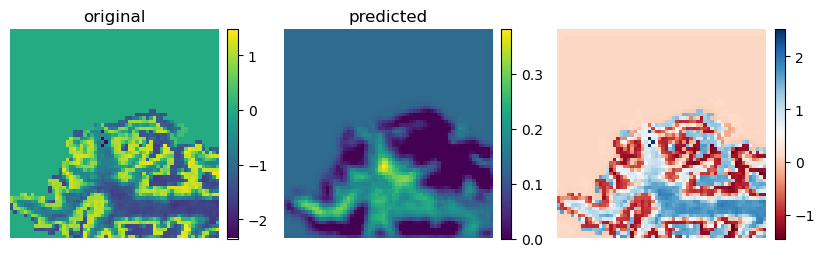

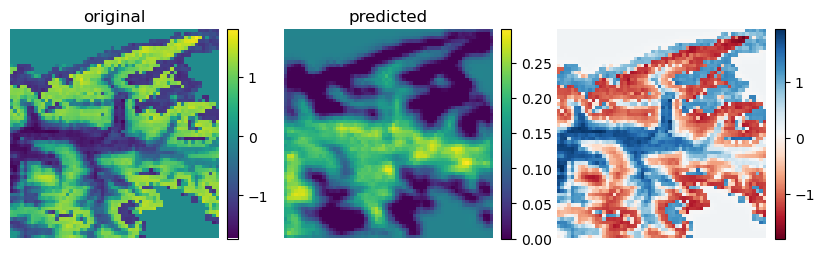

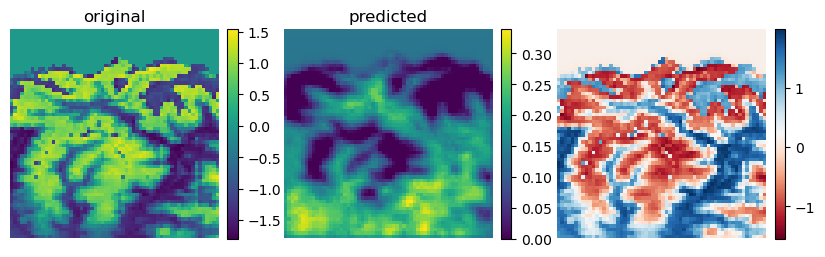

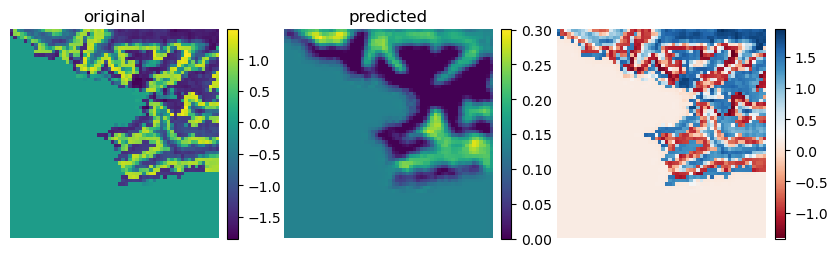

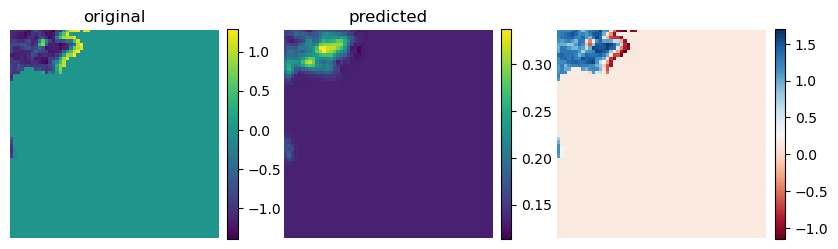

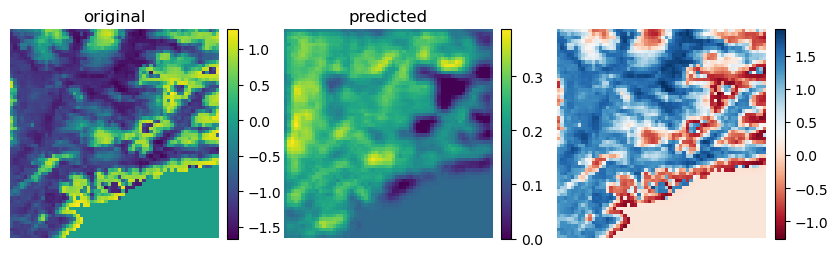

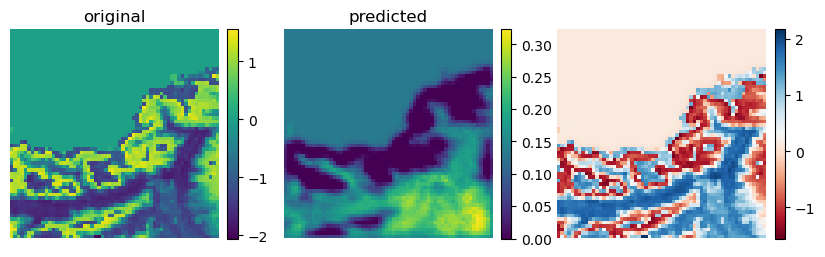

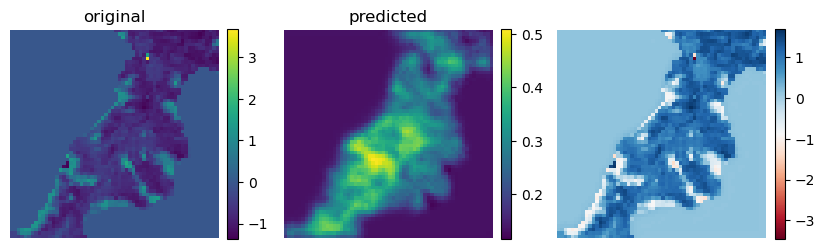

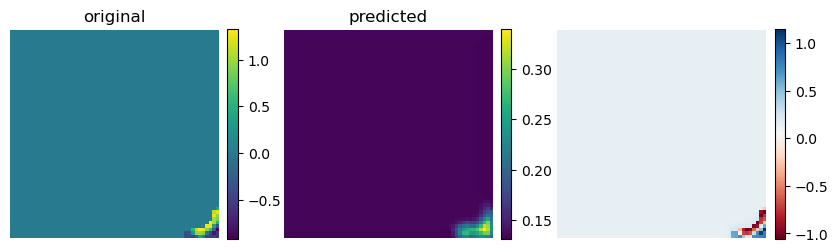

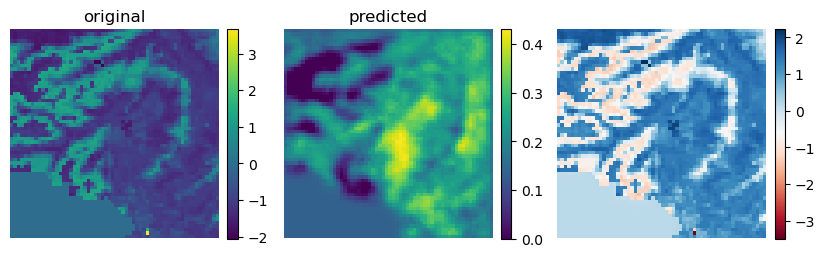

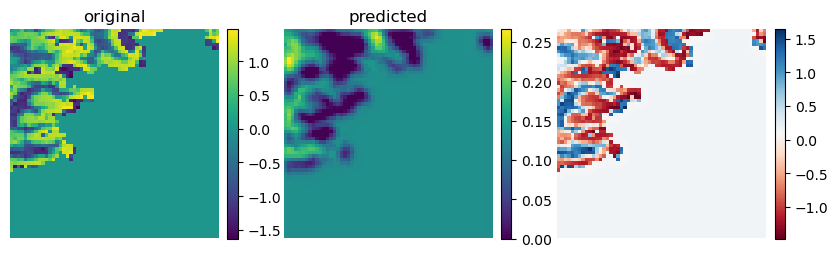

In [164]:
VARIABLE = 0
# target
for i in range(output.shape[0]):
    fig, axs = plt.subplots(1,3, figsize = (10,4))
    p1 = axs[0].imshow(res[2][i,-1,VARIABLE,:,:])
    axs[0].axis("off")
    plt.colorbar(p1,fraction=0.046, pad=0.04)
    axs[0].set_title("original")
    p2 = axs[1].imshow(output[i,-1,:,:,VARIABLE])
    plt.colorbar(p2,fraction=0.046, pad=0.04)
    axs[1].set_title("predicted")
    axs[1].axis("off")
    p3 = axs[2].imshow((output[i,-1,:,:,VARIABLE] - np.array(res[2][i,-1,VARIABLE,:,:])), cmap="RdBu")
    plt.colorbar(p3,fraction=0.046, pad=0.04)
    axs[2].axis("off")

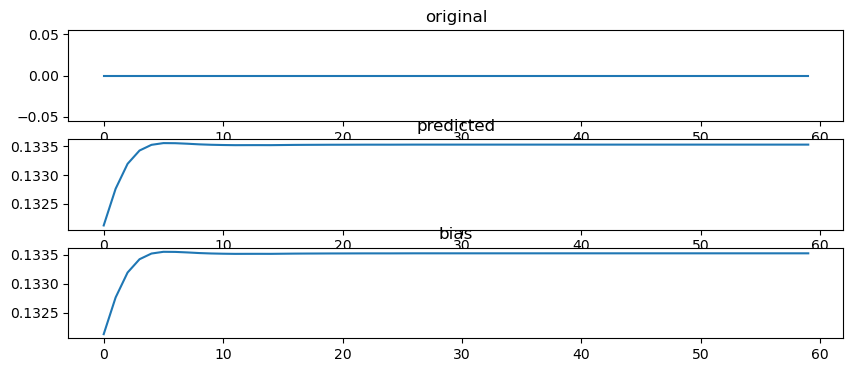

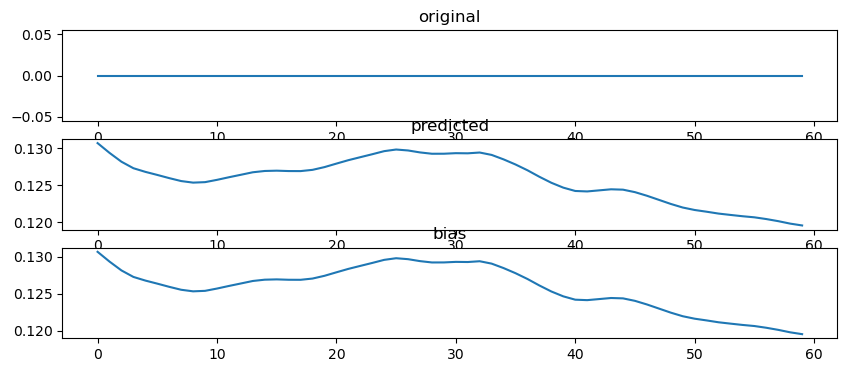

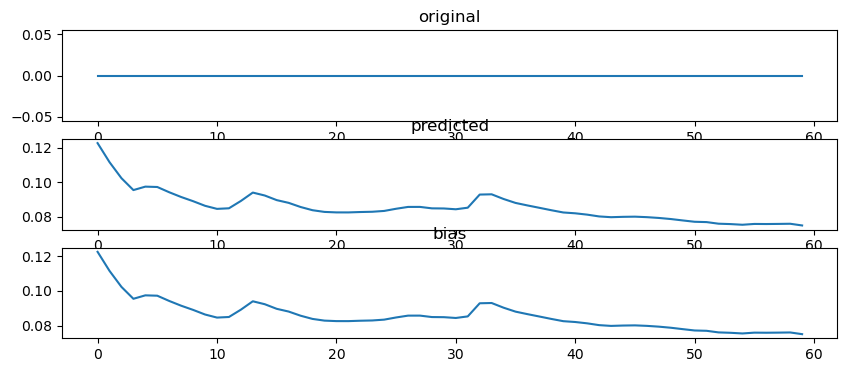

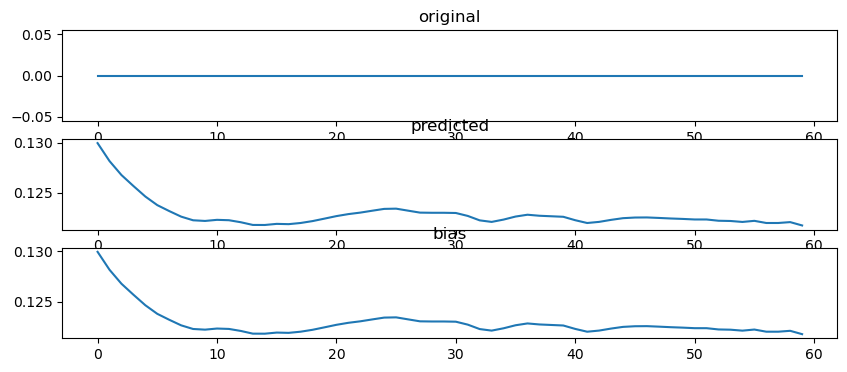

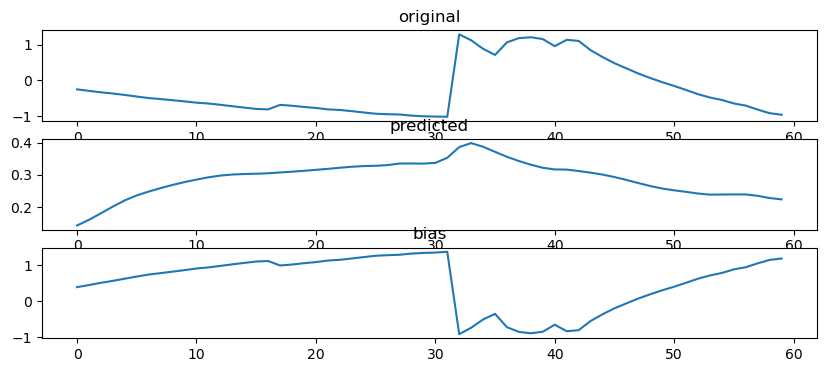

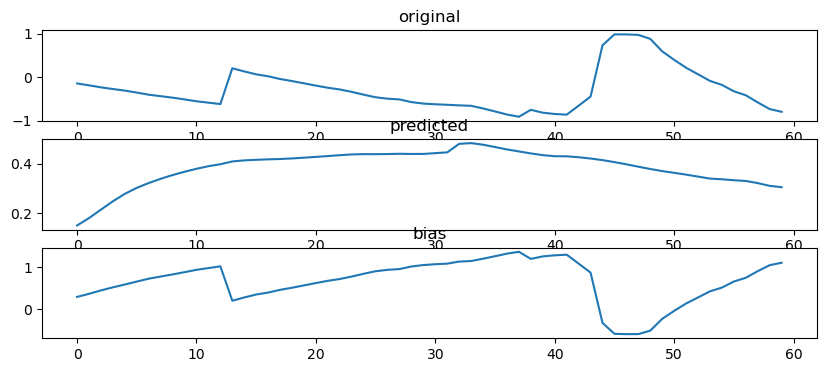

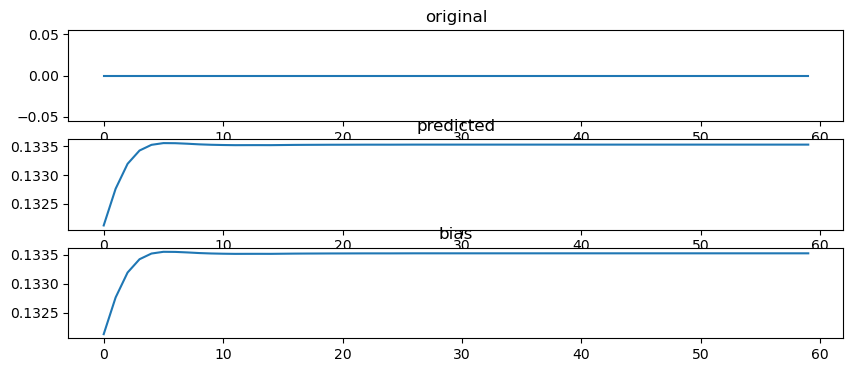

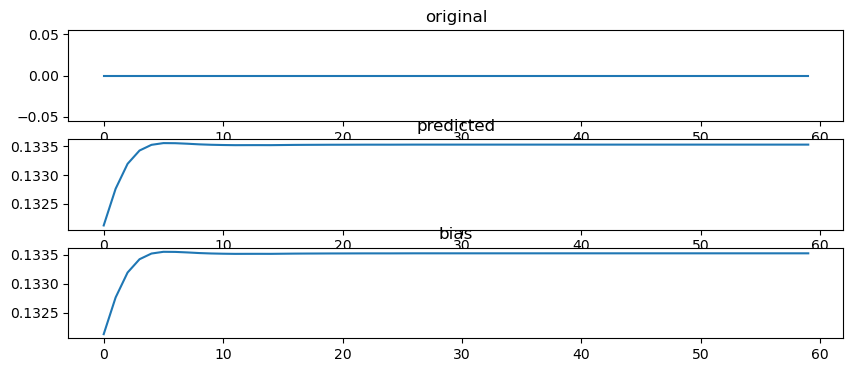

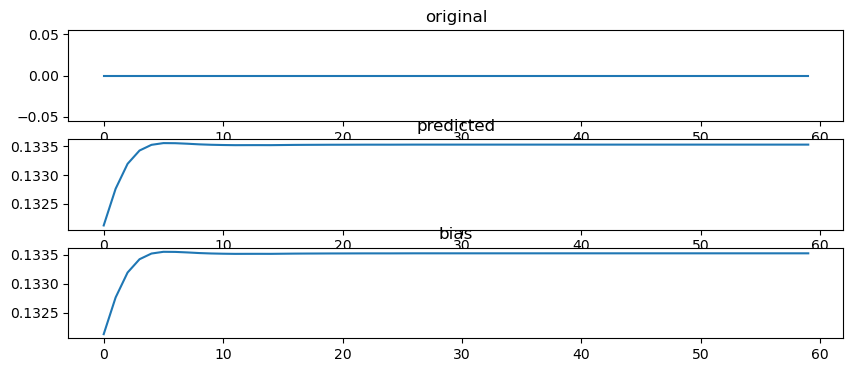

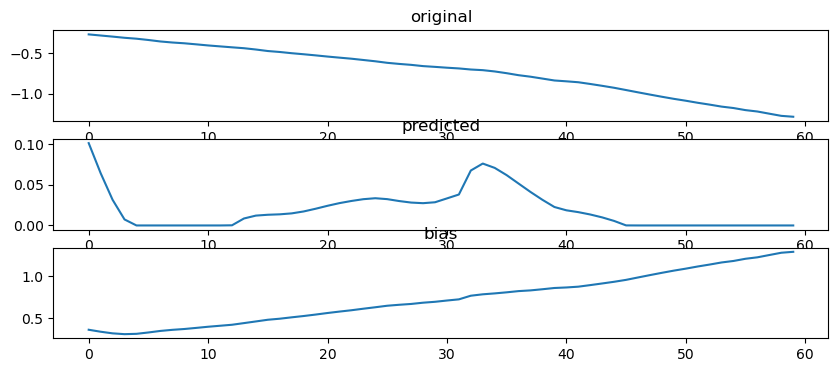

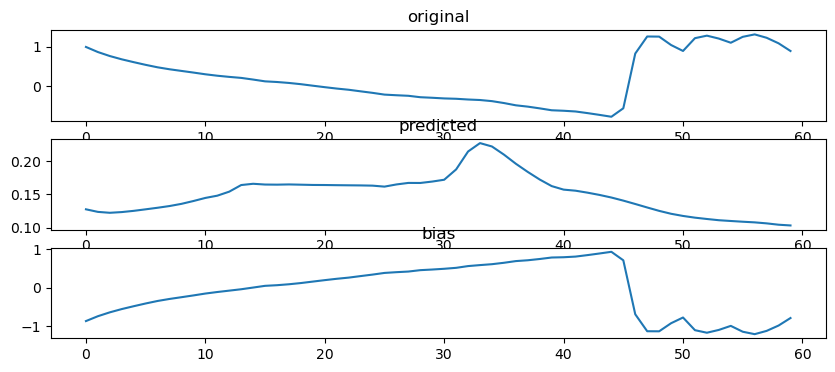

In [165]:
VARIABLE = 0
# target
for i in range(output.shape[0]):
    fig, axs = plt.subplots(3,1, figsize = (10,4))
    p1 = axs[0].plot(res[2][i,:,VARIABLE,10,10])
    #axs[0].axis("off")
    #plt.colorbar(p1,fraction=0.046, pad=0.04)
    axs[0].set_title("original")
    p2 = axs[1].plot(output[i,: ,10, 10,VARIABLE])
    #plt.colorbar(p2,fraction=0.046, pad=0.04)
    axs[1].set_title("predicted")
    #axs[1].axis("off")
    p3 = axs[2].plot((output[i,:,10,10,VARIABLE] - np.array(res[2][i,:,VARIABLE,10,10]))) #, cmap="RdBu")
    #plt.colorbar(p3,fraction=0.046, pad=0.04)
    #axs[2].axis("off")
    axs[2].set_title("bias")


In [97]:
torch

<module 'torch' from '/home/iferrario/.local/miniforge/envs/emulator/lib/python3.11/site-packages/torch/__init__.py'>

In [ ]:
torch.split?